# Recreating the Adapter-free model as outlined in the paper by Jonghan et al. 

Source: https://www.biorxiv.org/content/10.1101/2024.12.22.629997v1.full

In [1]:
'''
Imports
'''

proj_dir = '/Users/prabh/200 RESEARCH/Cluster Expansion Project'

# gives the notebook access to the cluster_expansion personal library
from sys import path
path.append(proj_dir)
import cluster_expansion as ce
from cluster_expansion import os, pd, np, plt, sns, tf, Markdown, display, train_test_split
from scipy.optimize import curve_fit

/Users/prabh/200 RESEARCH/Cluster Expansion Project/venv/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
KERNEL_SHAPE = (7, 4)

## 1. Training and testing the predictive model on the tiling and chrV library

This will allow us to use that model to predict on the ChrV library at a 1-base resolution, which will then be used to train the adapter-free model

### a. Data loading

In [3]:
# loading in the ChrV library

chrV = pd.read_csv('../Data/ChrV/ChrV.dat', sep = '\t')
tiling = pd.read_csv('../Data/Tiling/Tiling.dat', sep = '\t')

display(chrV.head())
display(tiling.head())

,Sequence,C0free,C0,C26,C26 count,C26 count sample,C29,C29 count,C29 count sample,C31,C31 count,C31 count sample,Amplitude,Phase
0,CGTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAA...,-0.220847,-0.069223,-0.205912,14,9,-0.781882,26,8,0.015182,17,14,-0.650093,0.211841
1,TCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACT...,-0.374313,-0.688533,-0.388233,38,14,-0.563193,48,22,-1.083431,49,24,-0.350048,-2.110462
2,CCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTACC...,-0.300181,-0.464485,-0.947849,41,6,0.065416,24,19,0.277546,33,32,0.584360,-0.974048
3,TCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTACCTTTATTT...,-0.091877,0.383790,0.702216,230,325,0.541498,241,426,-0.031338,265,314,0.382364,0.984116
4,CCCGGATGTTCAACCAAAAGCTACTTACTACCTTTATTTTATGTTT...,0.063294,0.122761,0.587374,473,634,-0.069926,474,424,-0.544434,555,363,-0.467108,-1.467391


,Sequence,C0free,C0,C26,C26 count,C26 count sample,C29,C29 count,C29 count sample,C31,C31 count,C31 count sample,Amplitude,Phase
0,GTGATCTTCTCTTGCTCATTGCATTTGGAACTGAGACAGAAGAATG...,-0.565669,-0.588446,-0.632139,634,259,-0.780557,848,305,-0.556275,717,442,-0.178446,0.247366
1,TCTCTTGCTCATTGCATTTGGAACTGAGACAGAAGAATGACGAGTT...,-0.580068,-0.499639,-0.102749,861,587,-0.507730,866,333,-1.046822,750,323,-0.407187,-1.796163
2,CTCATTGCATTTGGAACTGAGACAGAAGAATGACGAGTTACCACCC...,-0.467124,-0.334965,-0.437719,646,317,-0.684819,689,211,-0.244482,684,547,-0.336848,0.309987
3,CATTTGGAACTGAGACAGAAGAATGACGAGTTACCACCCTCCTAGC...,-0.229265,-0.439175,-1.121353,528,125,0.130155,826,633,0.582101,644,1135,0.750424,-1.141014
4,AACTGAGACAGAAGAATGACGAGTTACCACCCTCCTAGCATCTGGC...,-0.061227,-0.158107,0.152258,1337,1352,0.257966,1523,1263,-0.524573,1397,873,0.528598,0.627531


### b. Filtering low count sequences

In [4]:
# deleting low count sequences

chrV['uncertainty26'] = np.sqrt(1/(chrV['C26 count'])) + np.sqrt(1/(chrV['C26 count sample'])) + np.sqrt(1/(chrV['C26 count'] * chrV['C26 count sample']))
chrV['uncertainty29'] = np.sqrt(1/(chrV['C29 count'])) + np.sqrt(1/(chrV['C29 count sample'])) + np.sqrt(1/(chrV['C29 count'] * chrV['C29 count sample']))
chrV['uncertainty31'] = np.sqrt(1/(chrV['C31 count'])) + np.sqrt(1/(chrV['C31 count sample'])) + np.sqrt(1/(chrV['C31 count'] * chrV['C31 count sample']))

chrV = chrV.loc[(chrV['uncertainty26'] <= 0.1) & (chrV['uncertainty29'] <= 0.1) & (chrV['uncertainty31'] <= 0.1)].reset_index(drop=True)

display(chrV.head())
print(f'Number of sequences in filtered ChrV library: {chrV.shape[0]}')

chrV_seqs = chrV['Sequence']
chrV_c0 = chrV['C0'].values.reshape(-1, 1)
chrV_c0free = chrV['C0free'].values.reshape(-1, 1)
chrV_onehot = ce.Data2Onehot(chrV_seqs).reshape(-1, 200, 1)

tiling['uncertainty26'] = np.sqrt(1/(tiling['C26 count'])) + np.sqrt(1/(tiling['C26 count sample'])) + np.sqrt(1/(tiling['C26 count'] * tiling['C26 count sample']))
tiling['uncertainty29'] = np.sqrt(1/(tiling['C29 count'])) + np.sqrt(1/(tiling['C29 count sample'])) + np.sqrt(1/(tiling['C29 count'] * tiling['C29 count sample']))
tiling['uncertainty31'] = np.sqrt(1/(tiling['C31 count'])) + np.sqrt(1/(tiling['C31 count sample'])) + np.sqrt(1/(tiling['C31 count'] * tiling['C31 count sample']))

tiling = tiling.loc[(tiling['uncertainty26'] <= 0.1) & (tiling['uncertainty29'] <= 0.1) & (tiling['uncertainty31'] <= 0.1)].reset_index(drop=True)

display(tiling.head())
print(f'Number of sequences in filtered tiling library: {tiling.shape[0]}')

tiling_seqs = tiling['Sequence']
tiling_c0 = tiling['C0'].values.reshape(-1, 1)
tiling_c0free = tiling['C0free'].values.reshape(-1, 1)
tiling_onehot = ce.Data2Onehot(tiling_seqs).reshape(-1, 200, 1)

,Sequence,C0free,C0,C26,C26 count,C26 count sample,C29,C29 count,C29 count sample,C31,C31 count,C31 count sample,Amplitude,Phase,uncertainty26,uncertainty29,uncertainty31
0,CCCGGATGTTCAACCAAAAGCTACTTACTACCTTTATTTTATGTTT...,0.063294,0.122761,0.587374,473,634,-0.069926,474,424,-0.544434,555,363,-0.467108,-1.467391,0.087521,0.096726,0.097162
1,CAAAAGCTACTTACTACCTTTATTTTATGTTTACTTTTTATAGATT...,-0.028360,0.135381,0.222222,545,610,0.475479,674,1094,0.065371,755,817,0.320616,0.274284,0.085058,0.069917,0.072653
2,TACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCCTA...,-0.473126,-0.476540,-0.728838,1002,385,-0.845734,1012,421,-0.183140,1105,837,-0.451131,0.593489,0.084166,0.081704,0.065688
3,ATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCCTACTCTTTC...,-0.521105,-0.708203,-0.776545,849,357,-0.206905,1034,825,-0.541282,1072,661,0.412226,-0.166556,0.089062,0.066997,0.070626
4,GTTTACTTTTTATAGATTGTCTTTTTATCCTACTCTTTCCCACTTG...,-0.453445,-0.705238,-0.417433,827,466,-0.825041,1017,456,-1.118599,1231,410,-0.289390,-1.466109,0.082708,0.079655,0.079296


Number of sequences in filtered ChrV library: 592
Encoded all sequences to onehot


,Sequence,C0free,C0,C26,C26 count,C26 count sample,C29,C29 count,C29 count sample,C31,C31 count,C31 count sample,Amplitude,Phase,uncertainty26,uncertainty29,uncertainty31
0,TCTCTTGCTCATTGCATTTGGAACTGAGACAGAAGAATGACGAGTT...,-0.580068,-0.499639,-0.102749,861,587,-0.507730,866,333,-1.046822,750,323,-0.407187,-1.796163,0.076761,0.090643,0.094188
1,AACTGAGACAGAAGAATGACGAGTTACCACCCTCCTAGCATCTGGC...,-0.061227,-0.158107,0.152258,1337,1352,0.257966,1523,1263,-0.524573,1397,873,0.528598,0.627531,0.055289,0.054484,0.061505
2,ACAGAAGAATGACGAGTTACCACCCTCCTAGCATCTGGCTTGGCTT...,0.058063,0.298140,0.553833,628,878,-0.590355,788,298,-0.182829,608,544,-0.733366,-0.356137,0.074999,0.095616,0.085169
3,AATGACGAGTTACCACCCTCCTAGCATCTGGCTTGGCTTGTAAGGG...,0.112819,0.034231,-0.385620,790,414,0.414353,1133,1260,0.667105,871,1713,0.472864,-1.092737,0.086474,0.058718,0.058864
4,AGTTACCACCCTCCTAGCATCTGGCTTGGCTTGTAAGGGATGGTCC...,0.100423,0.426913,0.583952,1052,1334,0.394489,1297,1300,0.206157,736,828,0.157447,1.498814,0.059055,0.056272,0.072894


Number of sequences in filtered tiling library: 45439
Encoded all sequences to onehot


In [5]:
# merge high count data to one dataset
highCount = pd.concat([tiling, chrV])

display(highCount.head(), highCount.tail())

# extract training columns
seqs = highCount['Sequence'].values
c0s = highCount['C0'].values.reshape(-1, 1)
C26 = highCount['C26'].values.reshape(-1, 1)
C29 = highCount['C29'].values.reshape(-1, 1)
C31 = highCount['C31'].values.reshape(-1, 1)

,Sequence,C0free,C0,C26,C26 count,C26 count sample,C29,C29 count,C29 count sample,C31,C31 count,C31 count sample,Amplitude,Phase,uncertainty26,uncertainty29,uncertainty31
0,TCTCTTGCTCATTGCATTTGGAACTGAGACAGAAGAATGACGAGTT...,-0.580068,-0.499639,-0.102749,861,587,-0.507730,866,333,-1.046822,750,323,-0.407187,-1.796163,0.076761,0.090643,0.094188
1,AACTGAGACAGAAGAATGACGAGTTACCACCCTCCTAGCATCTGGC...,-0.061227,-0.158107,0.152258,1337,1352,0.257966,1523,1263,-0.524573,1397,873,0.528598,0.627531,0.055289,0.054484,0.061505
2,ACAGAAGAATGACGAGTTACCACCCTCCTAGCATCTGGCTTGGCTT...,0.058063,0.298140,0.553833,628,878,-0.590355,788,298,-0.182829,608,544,-0.733366,-0.356137,0.074999,0.095616,0.085169
3,AATGACGAGTTACCACCCTCCTAGCATCTGGCTTGGCTTGTAAGGG...,0.112819,0.034231,-0.385620,790,414,0.414353,1133,1260,0.667105,871,1713,0.472864,-1.092737,0.086474,0.058718,0.058864
4,AGTTACCACCCTCCTAGCATCTGGCTTGGCTTGTAAGGGATGGTCC...,0.100423,0.426913,0.583952,1052,1334,0.394489,1297,1300,0.206157,736,828,0.157447,1.498814,0.059055,0.056272,0.072894


,Sequence,C0free,C0,C26,C26 count,C26 count sample,C29,C29 count,C29 count sample,C31,C31 count,C31 count sample,Amplitude,Phase,uncertainty26,uncertainty29,uncertainty31
587,TTATTTAATCGTCAAATATAGTCCGATTTGTCTCATTATTCTTGTG...,0.525462,0.881500,1.326452,440,1254,0.606878,367,567,0.229436,451,613,-0.461443,-1.302646,0.077259,0.096388,0.089380
588,CTACTACCTAGATATTCTGCAATTTTTCCTATAATATAATATGCCT...,0.100657,0.169764,0.582934,544,756,0.623844,487,898,-0.332604,661,506,0.637378,0.705262,0.080804,0.080197,0.085080
589,CAGCCAATCAATTTTAACTTCATTTAGAATAAAAATCTTTCCTCTT...,-0.106208,0.240962,0.214400,465,437,0.616534,409,776,0.332123,589,790,0.311772,-0.085303,0.096429,0.087120,0.078249
590,ATTTTGACTTCAAAGATCATCTATATCTTGATATAACATCTACCTG...,0.143841,0.420814,0.520986,510,689,0.746650,493,961,0.330391,575,721,0.316161,0.322395,0.084065,0.078749,0.080498
591,TGAAACAATACTAAAACATTACTCATATCATGCTTTTGGGTTACCA...,0.448711,0.554078,1.098429,339,731,0.857589,365,757,-0.150654,473,421,0.669931,0.948511,0.093308,0.090590,0.096958


In [6]:
# reshape data for training/testing

onehot = ce.Data2Onehot(seqs).reshape(-1, 200, 1)
onehotRC = ce.Data2Onehot(ce.SeqArr2RevCompArr(seqs)).reshape(-1, 200, 1)

Encoded all sequences to onehot
Encoded all sequences to onehot


### b. Model Training - Yonghans

In [7]:
# fitting the model to the training data

save = False
overwrite = False
dir = '../CNN_models/RC_variant/Yonghan/'

try:
  assert os.path.exists(f'{dir}Y_C26.keras') and os.path.exists(f'{dir}Y_C29.keras') and os.path.exists(f'{dir}Y_C31.keras'), "One or more model files do not exist"
  assert (overwrite == False)
  Y_C26 = tf.keras.models.load_model(f'{dir}Y_C26.keras')
  Y_C29 = tf.keras.models.load_model(f'{dir}Y_C29.keras')
  Y_C31 = tf.keras.models.load_model(f'{dir}Y_C31.keras')

except Exception as e:
  Y_C26 = ce.YonghansArchitecture()
  Y_C29 = ce.YonghansArchitecture()
  Y_C31 = ce.YonghansArchitecture()
  Y_C26.fit(onehot, C26, epochs = 4, validation_split = 0.1)
  Y_C29.fit(onehot, C29, epochs = 4, validation_split = 0.1)
  Y_C31.fit(onehot, C31, epochs = 4, validation_split = 0.1)

  if save:
    Y_C26.save(f'{dir}Y_C26.keras')
    Y_C29.save(f'{dir}Y_C29.keras')
    Y_C31.save(f'{dir}Y_C31.keras')

In [8]:
# testing Yonghan models on the training data

Y_C26_trainPredictions = Y_C26.predict(onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C26, Y_C26_trainPredictions)
print(f'\tY_C26 Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Y_C29_trainPredictions = Y_C29.predict(onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C29, Y_C29_trainPredictions)
print(f'\tY_C29 Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Y_C31_trainPredictions = Y_C31.predict(onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C31, Y_C31_trainPredictions)
print(f'\tY_C31 Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# testing Yonghan models on the filtered tiling library

Y_C26_tilingPredictions = Y_C26.predict(tiling_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(tiling['C26'].values.reshape(-1, 1), Y_C26_tilingPredictions)
print(f'\tY_C26 Correlation on tiling data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Y_C29_tilingPredictions = Y_C29.predict(tiling_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(tiling['C29'].values.reshape(-1, 1), Y_C29_tilingPredictions)
print(f'\tY_C29 Correlation on tiling data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Y_C31_tilingPredictions = Y_C31.predict(tiling_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(tiling['C31'].values.reshape(-1, 1), Y_C31_tilingPredictions)
print(f'\tY_C31 Correlation on tiling data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# testing Yonghan models on the filtered ChrV library

Y_C26_chrVPredictions = Y_C26.predict(chrV_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(chrV['C26'].values.reshape(-1, 1), Y_C26_chrVPredictions)
print(f'\tY_C26 Correlation on chrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Y_C29_chrVPredictions = Y_C29.predict(chrV_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(chrV['C29'].values.reshape(-1, 1), Y_C29_chrVPredictions)
print(f'\tY_C29 Correlation on chrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Y_C31_chrVPredictions = Y_C31.predict(chrV_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(chrV['C31'].values.reshape(-1, 1), Y_C31_chrVPredictions)
print(f'\tY_C31 Correlation on chrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Y_C26 Correlation on training data: 0.941, [-0.001, 0.001]
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Y_C29 Correlation on training data: 0.9624, [-0.0007, 0.0007]
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Y_C31 Correlation on training data: 0.9664, [-0.0006, 0.0006]
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Y_C26 Correlation on tiling data: 0.940, [-0.001, 0.001]
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Y_C29 Correlation on tiling data: 0.9621, [-0.0007, 0.0007]
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	Y_C31 Correlation on tiling data: 0.9662, [-0.0006, 0.0006]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
	Y_C26 Correlation on chrV data: 0.94, [-0.01, 0.01]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
	Y_C29 Correlation on chrV data: 0.958, [-0.007, 0.006]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
	Y_C31 Correlation on chrV data: 0.967, [-0.006, 0.005]


### c. Model Training - Margaritas

Same methods as above, just different model architecture

In [9]:
# fitting the model to the training data

save = False
overwrite = False
dir = '../CNN_models/RC_variant/Margarita/'

try:
  assert os.path.exists(f'{dir}M_C26.keras') and os.path.exists(f'{dir}M_C29.keras') and os.path.exists(f'{dir}M_C31.keras'), "One or more model files do not exist"
  assert (overwrite == False)
  M_C26 = tf.keras.models.load_model(f'{dir}M_C26.keras')
  M_C29 = tf.keras.models.load_model(f'{dir}M_C29.keras')
  M_C31 = tf.keras.models.load_model(f'{dir}M_C31.keras')

except Exception as e:
  M_C26 = ce.MargaritasArchitecture(Kernel=KERNEL_SHAPE)
  M_C29 = ce.MargaritasArchitecture(Kernel=KERNEL_SHAPE)
  M_C31 = ce.MargaritasArchitecture(Kernel=KERNEL_SHAPE)
  M_C26.fit(onehot, C26, epochs = 4, validation_split = 0.1)
  M_C29.fit(onehot, C29, epochs = 4, validation_split = 0.1)
  M_C31.fit(onehot, C31, epochs = 4, validation_split = 0.1)

  if save:
    M_C26.save(f'{dir}M_C26.keras')
    M_C29.save(f'{dir}M_C29.keras')
    M_C31.save(f'{dir}M_C31.keras')

In [10]:
# testing Yonghan models on the training data

M_C26_trainPredictions = Y_C26.predict(onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C26, M_C26_trainPredictions)
print(f'\tM_C26 Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

M_C29_trainPredictions = Y_C29.predict(onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C29, M_C29_trainPredictions)
print(f'\tM_C29 Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

M_C31_trainPredictions = Y_C31.predict(onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C31, M_C31_trainPredictions)
print(f'\tM_C31 Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# testing Yonghan models on the filtered tiling library

M_C26_tilingPredictions = Y_C26.predict(tiling_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(tiling['C26'].values.reshape(-1, 1), M_C26_tilingPredictions)
print(f'\tM_C26 Correlation on tiling data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

M_C29_tilingPredictions = Y_C29.predict(tiling_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(tiling['C29'].values.reshape(-1, 1), M_C29_tilingPredictions)
print(f'\tM_C29 Correlation on tiling data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

M_C31_tilingPredictions = Y_C31.predict(tiling_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(tiling['C31'].values.reshape(-1, 1), M_C31_tilingPredictions)
print(f'\tM_C31 Correlation on tiling data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# testing Yonghan models on the filtered ChrV library

M_C26_chrVPredictions = Y_C26.predict(chrV_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(chrV['C26'].values.reshape(-1, 1), M_C26_chrVPredictions)
print(f'\tM_C26 Correlation on chrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

M_C29_chrVPredictions = Y_C29.predict(chrV_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(chrV['C29'].values.reshape(-1, 1), M_C29_chrVPredictions)
print(f'\tM_C29 Correlation on chrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

M_C31_chrVPredictions = Y_C31.predict(chrV_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(chrV['C31'].values.reshape(-1, 1), M_C31_chrVPredictions)
print(f'\tM_C31 Correlation on chrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	M_C26 Correlation on training data: 0.941, [-0.001, 0.001]
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	M_C29 Correlation on training data: 0.9624, [-0.0007, 0.0007]
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	M_C31 Correlation on training data: 0.9664, [-0.0006, 0.0006]
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	M_C26 Correlation on tiling data: 0.940, [-0.001, 0.001]
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	M_C29 Correlation on tiling data: 0.9621, [-0.0007, 0.0007]
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
	M_C31 Correlation on tiling data: 0.9662, [-0.0006, 0.0006]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
	M_C26 Correlation on chrV data: 0.94, [-0.01, 0.01]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
	M_C29 Correlation on chrV data: 0.958, [-0.007, 0.006]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
	M_C31 Correlation on chrV data: 0.967, [-0.006, 0.005]


### d. Symmetric Model

In [11]:
# fitting the model to the training data

save = False
overwrite = False
dir = '../CNN_models/RC_variant/Symmetric/'

try:
  assert os.path.exists(f'{dir}S_C0.keras'), "Symmetric model file does not exist"
  assert (overwrite == False)
  S_C0 = tf.keras.models.load_model(f'{dir}S_C0.keras')

except Exception as e:
  S_C0 = ce.SymmetricArchitecture(Kernel = KERNEL_SHAPE)
  S_C0.fit([onehot, onehotRC], c0s, epochs = 4, validation_split = 0.1)

  if save:
    S_C0.save(f'{dir}S_C0.keras')

In [12]:
# testing Symmetric model on the training data

SymmetricModel_trainPredictions = S_C0.predict(onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(c0s, SymmetricModel_trainPredictions)
print(f'\tSymmetric Model Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# testing Symmetric model on the filtered tiling library

SymmetricModel_tilingPredictions = S_C0.predict(tiling_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(tiling_c0, SymmetricModel_tilingPredictions)
print(f'\tSymmetric Model Correlation on tiling data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# testing Symmetric model on the filtered ChrV library

SymmetricModel_chrVPredictions = S_C0.predict(chrV_onehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(chrV_c0, SymmetricModel_chrVPredictions)
print(f'\tSymmetric Model Correlation on chrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

180/180 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step
	Symmetric Model Correlation on training data: 0.9497, [-0.0009, 0.0009]
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step
	Symmetric Model Correlation on tiling data: 0.9492, [-0.0009, 0.0009]
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
	Symmetric Model Correlation on chrV data: 0.954, [-0.008, 0.007]


In [13]:
# testing Symmetric model on reverse complement sequences

TestSequences = tiling['Sequence']
TestSequences_RC = ce.SeqArr2RevCompArr(TestSequences)

TestOnehot = ce.Data2Onehot(TestSequences).reshape(-1, 200, 1)
TestOnehot_RC = ce.Data2Onehot(TestSequences_RC).reshape(-1, 200, 1)

# predict c0 values for sequences and their onehot
Predictions = S_C0.predict(TestOnehot, batch_size = 256)
Predictions_RC = S_C0.predict(TestOnehot_RC, batch_size = 256)

r, se_z, prec, d_low, d_high = ce.pearson(Predictions, Predictions_RC)
print(f'Correlation of Symmetric Model on Reverse Complement Sequences: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Encoded all sequences to onehot
Encoded all sequences to onehot
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step
Correlation of Symmetric Model on Reverse Complement Sequences: 0.9835, [-0.0003, 0.0003]


## 2. Preparing the ChrV library for Training the second model

### a. ChrV Data at 7bp resolution -> 1 bp resolution

In [17]:
# converting the entire ChrV library into a single string of DNA

ChrVData = pd.read_csv('../Data/ChrV/ChrV.dat', delimiter = '\t')
ChrVData.columns = ChrVData.columns.str.strip()
ChrVData = ChrVData.drop(['C26 count', 'C26 count sample', 'C29 count', 'C29 count sample', 'C31 count', 'C31 count sample'], axis=1)
display(ChrVData.head())

fullChrV = ChrVData['Sequence'][0]

# add the 7 non-overlapping sequences in each iteration to the full string
for sequence in ChrVData['Sequence'][1:]:
    fullChrV += sequence[-7:]

print(f'Number of DNA characters in the full ChrV sequence: {len(fullChrV)}')

# get rid of the edge windows
fullChrV = fullChrV[50:-50]

# create a numpy array storing the ChrV at a 1 bp resolution

chrV_1bpSeqs = np.array([fullChrV[i:i+50] for i in range(len(fullChrV) - 49)], dtype = 'object')

print(f'Number of ChrV sequences at the 1 bp resolution: {len(chrV_1bpSeqs)}')

assert all(len(seq) == 50 for seq in chrV_1bpSeqs), 'Some of the sequences are not of length 50 in ChrV_1bpRes_Seqs'

display(pd.DataFrame(chrV_1bpSeqs))

,Sequence,C0free,C0,C26,C29,C31,Amplitude,Phase
0,CGTCTCCTCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAA...,-0.220847,-0.069223,-0.205912,-0.781882,0.015182,-0.650093,0.211841
1,TCCAAGCCCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACT...,-0.374313,-0.688533,-0.388233,-0.563193,-1.083431,-0.350048,-2.110462
2,CCTGTTGTCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTACC...,-0.300181,-0.464485,-0.947849,0.065416,0.277546,0.584360,-0.974048
3,TCTCTTACCCGGATGTTCAACCAAAAGCTACTTACTACCTTTATTT...,-0.091877,0.383790,0.702216,0.541498,-0.031338,0.382364,0.984116
4,CCCGGATGTTCAACCAAAAGCTACTTACTACCTTTATTTTATGTTT...,0.063294,0.122761,0.587374,-0.069926,-0.544434,-0.467108,-1.467391


Number of DNA characters in the full ChrV sequence: 571264
Number of ChrV sequences at the 1 bp resolution: 571115


,0
0,ACTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTT...
1,CTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTA...
2,TTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTAT...
3,TACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATC...
4,ACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCC...
...,...
571110,CAACAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATT...
571111,AACAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATTT...
571112,ACAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATTTA...
571113,CAGGGCTTGGAGGAGACGTACATGAGGGCTATTTAGGGCTATTTAG...


In [18]:
chrV_1bpOnehot = ce.Data2Onehot(chrV_1bpSeqs).reshape(-1, 200, 1)
chrV_1bpOnehotRC = ce.Data2Onehot(ce.SeqArr2RevCompArr(chrV_1bpSeqs)).reshape(-1, 200, 1)

Encoded all sequences to onehot
Encoded all sequences to onehot


### b. Using Both Models to predict a cyclizability for each sequence in the 1 bp Resolution

#### i. Yonghans Model

In [19]:
# Predict C26, C29, C31 for each 1bp resolution window with `Yonghans Model`
try:
  Y_chrV = pd.read_csv('../Data/ChrV/ChrV_1bp_Y.dat', sep='\t')
  Y_C26_chrV = Y_chrV['C26'].values
  Y_C26_chrV_RC = Y_chrV['C26_RC'].values
  Y_C29_chrV = Y_chrV['C29'].values
  Y_C29_chrV_RC = Y_chrV['C29_RC'].values
  Y_C31_chrV = Y_chrV['C31'].values
  Y_C31_chrV_RC = Y_chrV['C31_RC'].values
  display(Y_chrV.head())
except FileNotFoundError:
  print("File not found, generating predictions...")
  Y_C26_chrV = Y_C26.predict(chrV_1bpOnehot, batch_size = 256)
  Y_C26_chrV_RC = Y_C26.predict(chrV_1bpOnehotRC, batch_size = 256)
  Y_C29_chrV = Y_C29.predict(chrV_1bpOnehot, batch_size = 256)
  Y_C29_chrV_RC = Y_C29.predict(chrV_1bpOnehotRC, batch_size = 256)
  Y_C31_chrV = Y_C31.predict(chrV_1bpOnehot, batch_size = 256)
  Y_C31_chrV_RC = Y_C31.predict(chrV_1bpOnehotRC, batch_size = 256)

,Sequence,C26,C26_RC,C29,C29_RC,C31,C31_RC
0,ACTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTT...,-0.475268,-0.130639,-0.220423,-0.390378,-0.724402,-0.756646
1,CTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTA...,-0.528570,-0.237648,-0.021438,-0.477539,-0.352112,-0.979899
2,TTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTAT...,-0.739546,-0.366408,0.083509,-0.609835,-0.204654,-0.631882
3,TACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATC...,-0.785363,-0.380099,-0.151576,-0.537183,-0.195720,-0.342455
4,ACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCC...,-0.867341,-0.563757,-0.299397,-0.252682,-0.304751,-0.017044


In [20]:
Y_chrV = pd.DataFrame({
    'Sequence': chrV_1bpSeqs,
    'C26': Y_C26_chrV.flatten(),
    'C26_RC': Y_C26_chrV_RC.flatten(),
    'C29': Y_C29_chrV.flatten(), 
    'C29_RC': Y_C29_chrV_RC.flatten(),
    'C31': Y_C31_chrV.flatten(),
    'C31_RC': Y_C31_chrV_RC.flatten()
})

display(Y_chrV.head())

save = False
if save:
    Y_chrV.to_csv('../Data/ChrV/ChrV_1bp_Y.dat', sep='\t', index=False)


,Sequence,C26,C26_RC,C29,C29_RC,C31,C31_RC
0,ACTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTT...,-0.475268,-0.130639,-0.220423,-0.390378,-0.724402,-0.756646
1,CTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTA...,-0.528570,-0.237648,-0.021438,-0.477539,-0.352112,-0.979899
2,TTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTAT...,-0.739546,-0.366408,0.083509,-0.609835,-0.204654,-0.631882
3,TACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATC...,-0.785363,-0.380099,-0.151576,-0.537183,-0.195720,-0.342455
4,ACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCC...,-0.867341,-0.563757,-0.299397,-0.252682,-0.304751,-0.017044


#### ii. Margaritas Model

In [21]:
# Predict C26, C29, C31 for each 1bp resolution window with `Margaritas Model`
try:
  M_chrV = pd.read_csv('../Data/ChrV/ChrV_1bp_M.dat', sep='\t')
  M_C26_chrV = M_chrV['C26'].values
  M_C26_chrV_RC = M_chrV['C26_RC'].values
  M_C29_chrV = M_chrV['C29'].values
  M_C29_chrV_RC = M_chrV['C29_RC'].values
  M_C31_chrV = M_chrV['C31'].values
  M_C31_chrV_RC = M_chrV['C31_RC'].values
  display(M_chrV.head())
except FileNotFoundError:
  print("File not found, generating predictions...")
  M_C26_chrV = M_C26.predict(chrV_1bpOnehot, batch_size = 256)
  M_C26_chrV_RC = M_C26.predict(chrV_1bpOnehotRC, batch_size = 256)
  M_C29_chrV = M_C29.predict(chrV_1bpOnehot, batch_size = 256)
  M_C29_chrV_RC = M_C29.predict(chrV_1bpOnehotRC, batch_size = 256)
  M_C31_chrV = M_C31.predict(chrV_1bpOnehot, batch_size = 256)
  M_C31_chrV_RC = M_C31.predict(chrV_1bpOnehotRC, batch_size = 256)

,Sequence,C26,C26_RC,C29,C29_RC,C31,C31_RC
0,ACTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTT...,-0.481561,-0.088187,-0.423028,-0.531354,-0.965222,-0.965078
1,CTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTA...,-0.520602,-0.152206,-0.209653,-0.671300,-0.807053,-0.971665
2,TTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTAT...,-0.613459,-0.248076,-0.064728,-0.807684,-0.705206,-0.757111
3,TACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATC...,-0.644451,-0.361120,-0.083401,-0.836615,-0.484484,-0.541794
4,ACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCC...,-0.766436,-0.571334,-0.209227,-0.468245,-0.389265,-0.251929


In [22]:
M_chrV = pd.DataFrame({
  'Sequence': chrV_1bpSeqs,
  'C26': M_C26_chrV.flatten(),
  'C26_RC': M_C26_chrV_RC.flatten(),
  'C29': M_C29_chrV.flatten(), 
  'C29_RC': M_C29_chrV_RC.flatten(),
  'C31': M_C31_chrV.flatten(),
  'C31_RC': M_C31_chrV_RC.flatten()
})

display(M_chrV.head())

save = False
if save:
  M_chrV.to_csv('../Data/ChrV/ChrV_1bp_M.dat', sep='\t', index=False)

,Sequence,C26,C26_RC,C29,C29_RC,C31,C31_RC
0,ACTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTT...,-0.481561,-0.088187,-0.423028,-0.531354,-0.965222,-0.965078
1,CTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTA...,-0.520602,-0.152206,-0.209653,-0.671300,-0.807053,-0.971665
2,TTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTAT...,-0.613459,-0.248076,-0.064728,-0.807684,-0.705206,-0.757111
3,TACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATC...,-0.644451,-0.361120,-0.083401,-0.836615,-0.484484,-0.541794
4,ACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCC...,-0.766436,-0.571334,-0.209227,-0.468245,-0.389265,-0.251929


In [23]:
# Compare the predictions of Yonghan and Margarita models on ChrV data

# Now compare the predictions
r, se_z, prec, d_low, d_high = ce.pearson(Y_C26_chrV, M_C26_chrV)
print(f'Y_C26 vs M_C26 correlation on ChrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

r, se_z, prec, d_low, d_high = ce.pearson(Y_C29_chrV, M_C29_chrV)
print(f'Y_C29 vs M_C29 correlation on ChrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

r, se_z, prec, d_low, d_high = ce.pearson(Y_C31_chrV, M_C31_chrV)
print(f'Y_C31 vs M_C31 correlation on ChrV data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

Y_C26 vs M_C26 correlation on ChrV data: 0.9457, [-0.0003, 0.0003]
Y_C29 vs M_C29 correlation on ChrV data: 0.9655, [-0.0002, 0.0002]
Y_C31 vs M_C31 correlation on ChrV data: 0.9656, [-0.0002, 0.0002]


Both models are similar in their predictions, with a correlation of **~0.95** between the two predicting on the ChrV dataset for 571115 sequences

### c. Calculating the C0corr for both Models predicted C0 values

In [24]:
x = np.arange(len(Y_chrV))
print(x.shape)
print(Y_C26_chrV.shape)
print(Y_C26_chrV_RC.shape)
print(Y_C29_chrV.shape)
print(Y_C29_chrV_RC.shape)
print(Y_C31_chrV.shape)
print(Y_C31_chrV_RC.shape)

(571115,)
(571115,)
(571115,)
(571115,)
(571115,)
(571115,)
(571115,)


#### i. Yonghans Model

In [25]:
U26_Y, L26_Y = ce.envelope(x, Y_C26_chrV)
U29_Y, L29_Y = ce.envelope(x, Y_C29_chrV)
U31_Y, L31_Y = ce.envelope(x, Y_C31_chrV)
U26_Y_RC, L26_Y_RC = ce.envelope(x, Y_C26_chrV_RC)
U29_Y_RC, L29_Y_RC = ce.envelope(x, Y_C29_chrV_RC)
U31_Y_RC, L31_Y_RC = ce.envelope(x, Y_C31_chrV_RC)

display(pd.DataFrame({
  'Position': x,
  'Y_C26_Upper': U26_Y,
  'Y_C26_Lower': L26_Y,
  'Y_C29_Upper': U29_Y,
  'Y_C29_Lower': L29_Y,
  'Y_C31_Upper': U31_Y,
  'Y_C31_Lower': L31_Y,
  'Y_C26_Upper_RC': U26_Y_RC,
  'Y_C26_Lower_RC': L26_Y_RC,
  'Y_C29_Upper_RC': U29_Y_RC,
  'Y_C29_Lower_RC': L29_Y_RC,
  'Y_C31_Upper_RC': U31_Y_RC,
  'Y_C31_Lower_RC': L31_Y_RC
}).head())


print(f'Envelope ranges for Yonghan model:')
print(f'C26: [{L26_Y.min():.4f}, {U26_Y.max():.4f}]')
print(f'C29: [{L29_Y.min():.4f}, {U29_Y.max():.4f}]')
print(f'C31: [{L31_Y.min():.4f}, {U31_Y.max():.4f}]')
print(f'C26_RC: [{L26_Y_RC.min():.4f}, {U26_Y_RC.max():.4f}]')
print(f'C29_RC: [{L29_Y_RC.min():.4f}, {U29_Y_RC.max():.4f}]')
print(f'C31_RC: [{L31_Y_RC.min():.4f}, {U31_Y_RC.max():.4f}]')

,Position,Y_C26_Upper,Y_C26_Lower,Y_C29_Upper,Y_C29_Lower,Y_C31_Upper,Y_C31_Lower,Y_C26_Upper_RC,Y_C26_Lower_RC,Y_C29_Upper_RC,Y_C29_Lower_RC,Y_C31_Upper_RC,Y_C31_Lower_RC
0,0,-0.475268,-0.475268,-0.220423,-0.220423,-0.724402,-0.724402,-0.130639,-0.130639,-0.390378,-0.390378,-0.756646,-0.756646
1,1,-0.416806,-0.612721,-0.021438,-0.383356,-0.352112,-0.810820,-0.078127,-0.281437,-0.209732,-0.512896,-0.521191,-0.979899
2,2,-0.370386,-0.739546,0.083509,-0.522392,-0.204654,-0.884966,-0.037027,-0.409214,-0.062317,-0.609835,-0.327821,-1.137886
3,3,-0.334769,-0.806184,0.183323,-0.639198,-0.195720,-0.947609,-0.006546,-0.515700,0.054742,-0.683625,-0.172850,-1.238552
4,4,-0.308717,-0.867341,0.252394,-0.735443,-0.099724,-0.999519,0.014113,-0.602628,0.144323,-0.736694,-0.017044,-1.289842


Envelope ranges for Yonghan model:
C26: [-1.8553, 2.7286]
C29: [-1.7686, 2.2929]
C31: [-2.3513, 2.3981]
C26_RC: [-1.8711, 2.5439]
C29_RC: [-1.7740, 2.3677]
C31_RC: [-2.4893, 2.4620]


#### ii. Margaritas Model

In [26]:
# Calculate envelope for Margarita model predictions
U26_M, L26_M = ce.envelope(x, M_C26_chrV)
U29_M, L29_M = ce.envelope(x, M_C29_chrV)
U31_M, L31_M = ce.envelope(x, M_C31_chrV)
U26_M_RC, L26_M_RC = ce.envelope(x, M_C26_chrV_RC)
U29_M_RC, L29_M_RC = ce.envelope(x, M_C29_chrV_RC)
U31_M_RC, L31_M_RC = ce.envelope(x, M_C31_chrV_RC)

display(pd.DataFrame({
  'Position': x,
  'M_C26_Upper': U26_M,
  'M_C26_Lower': L26_M,
  'M_C29_Upper': U29_M,
  'M_C29_Lower': L29_M,
  'M_C31_Upper': U31_M,
  'M_C31_Lower': L31_M,
  'M_C26_Upper_RC': U26_M_RC,
  'M_C26_Lower_RC': L26_M_RC,
  'M_C29_Upper_RC': U29_M_RC,
  'M_C29_Lower_RC': L29_M_RC,
  'M_C31_Upper_RC': U31_M_RC,
  'M_C31_Lower_RC': L31_M_RC
}).head())

print(f'Envelope ranges for Margarita model:')
print(f'C26: [{L26_M.min():.4f}, {U26_M.max():.4f}]')
print(f'C29: [{L29_M.min():.4f}, {U29_M.max():.4f}]')
print(f'C31: [{L31_M.min():.4f}, {U31_M.max():.4f}]')
print(f'C26_RC: [{L26_M_RC.min():.4f}, {U26_M_RC.max():.4f}]')
print(f'C29_RC: [{L29_M_RC.min():.4f}, {U29_M_RC.max():.4f}]')
print(f'C31_RC: [{L31_M_RC.min():.4f}, {U31_M_RC.max():.4f}]')

,Position,M_C26_Upper,M_C26_Lower,M_C29_Upper,M_C29_Lower,M_C31_Upper,M_C31_Lower,M_C26_Upper_RC,M_C26_Lower_RC,M_C29_Upper_RC,M_C29_Lower_RC,M_C31_Upper_RC,M_C31_Lower_RC
0,0,-0.481561,-0.481561,-0.423028,-0.423028,-0.965222,-0.965222,-0.088187,-0.088187,-0.531354,-0.531354,-0.965078,-0.965078
1,1,-0.394824,-0.567224,-0.209653,-0.552637,-0.783485,-0.988256,-0.003927,-0.241452,-0.397832,-0.671300,-0.721094,-0.971665
2,2,-0.328781,-0.639304,-0.064728,-0.662069,-0.630916,-1.008730,0.058712,-0.370444,-0.283658,-0.807684,-0.517212,-0.973238
3,3,-0.281312,-0.698799,0.052430,-0.752796,-0.484484,-1.026645,0.101692,-0.477008,-0.187396,-0.836615,-0.350208,-0.970691
4,4,-0.250295,-0.766436,0.133173,-0.826291,-0.389265,-1.041999,0.126970,-0.571334,-0.107611,-0.888774,-0.216857,-0.964920


Envelope ranges for Margarita model:
C26: [-1.4180, 2.3237]
C29: [-1.7417, 2.4945]
C31: [-2.4924, 2.3431]
C26_RC: [-1.4323, 2.3099]
C29_RC: [-1.7541, 2.4416]
C31_RC: [-2.7512, 2.4988]


#### iii. Symmetric Model

(uses `ii. Margaritas Model`)

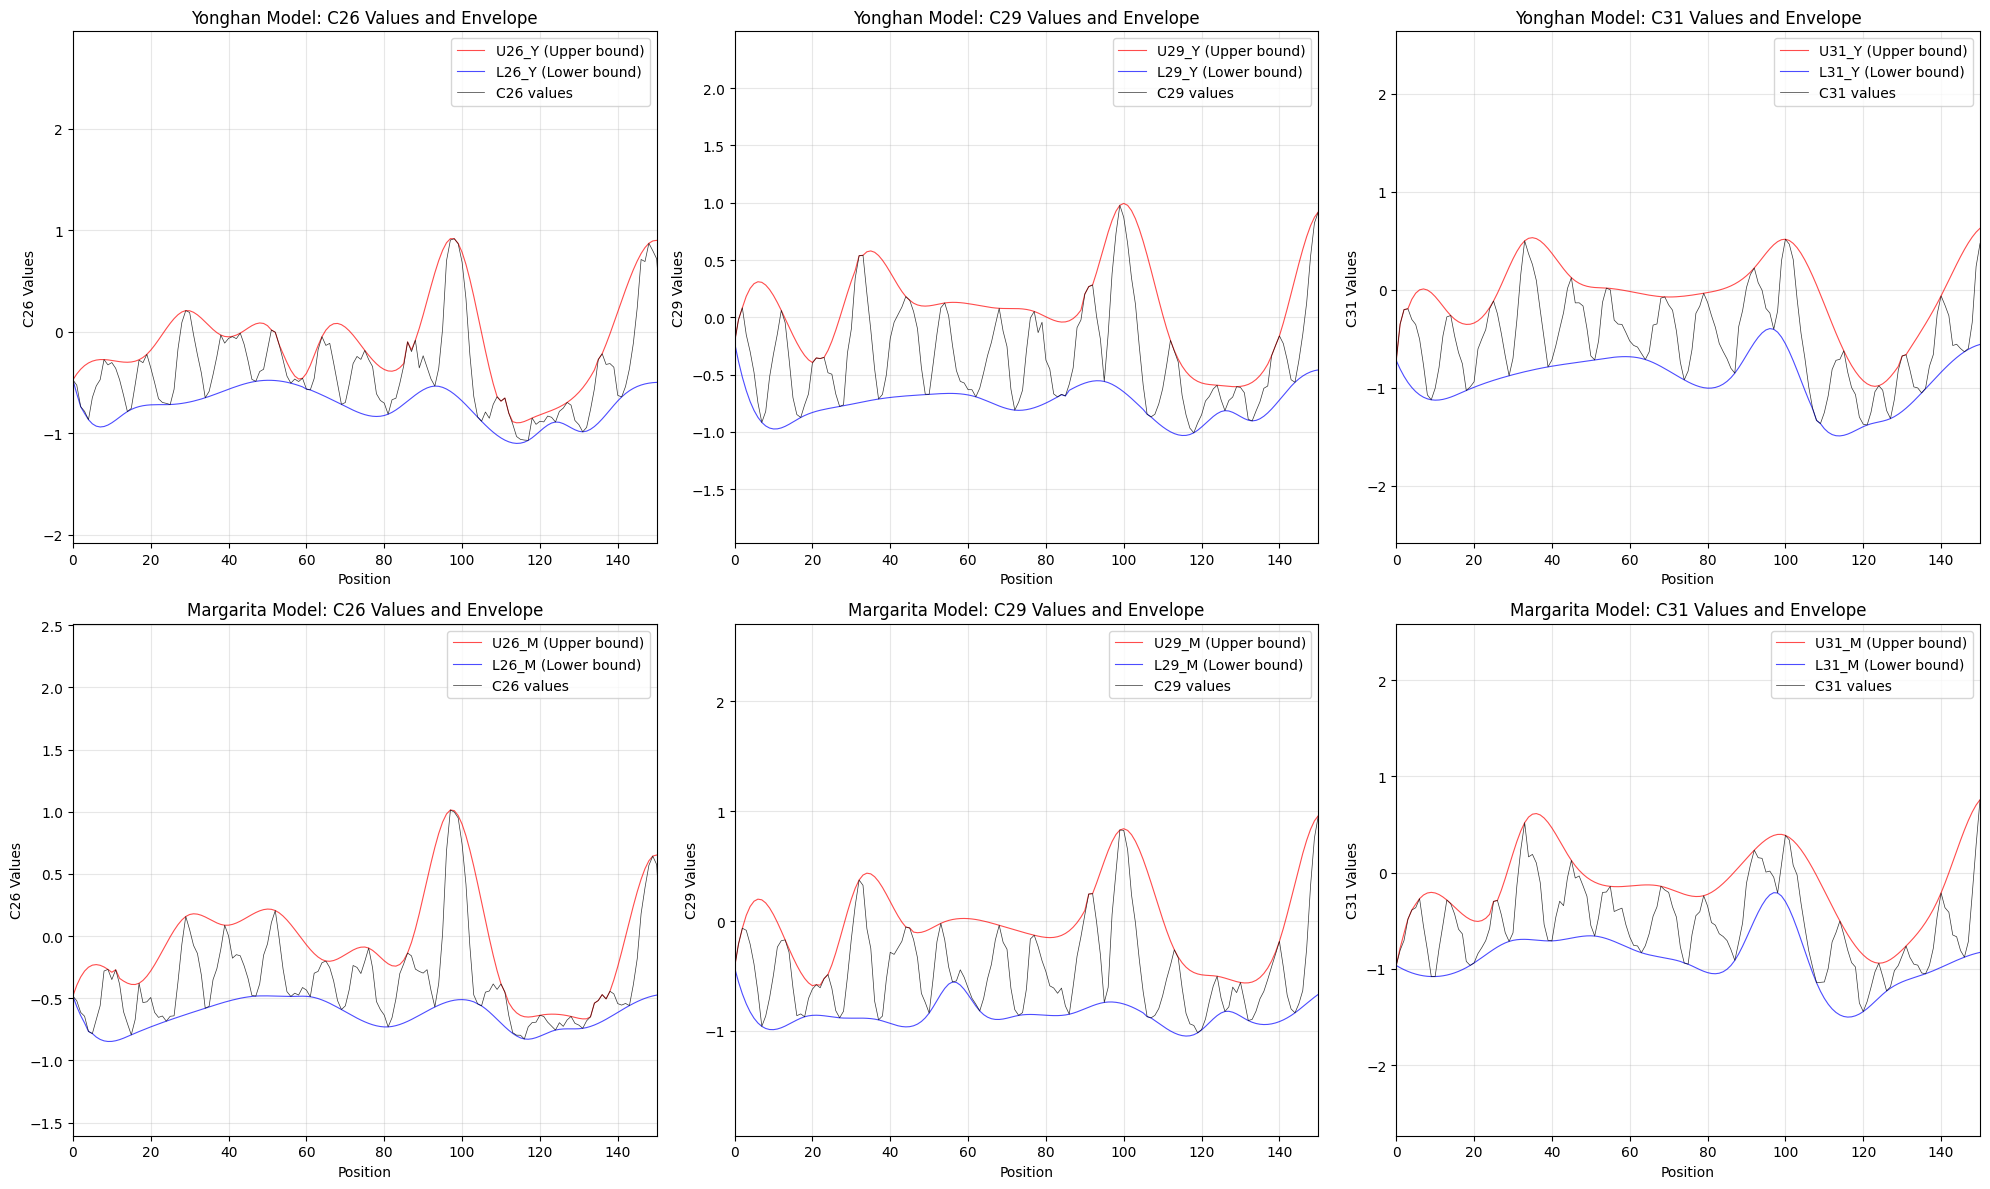

In [27]:
plt.figure(figsize=(20, 12))

# Define data for both models
models = {
  'Yonghan': {'U26': U26_Y, 'L26': L26_Y, 'C26': Y_C26_chrV, 
        'U29': U29_Y, 'L29': L29_Y, 'C29': Y_C29_chrV,
        'U31': U31_Y, 'L31': L31_Y, 'C31': Y_C31_chrV},
  'Margarita': {'U26': U26_M, 'L26': L26_M, 'C26': M_C26_chrV,
          'U29': U29_M, 'L29': L29_M, 'C29': M_C29_chrV, 
          'U31': U31_M, 'L31': L31_M, 'C31': M_C31_chrV}
}

# Loop through models and chain lengths
for model_idx, (model_name, data) in enumerate(models.items()):
  for chain_idx, chain_length in enumerate([26, 29, 31]):
    subplot_idx = model_idx * 3 + chain_idx + 1
    plt.subplot(2, 3, subplot_idx)
    
    # Plot upper and lower bounds and chain values
    plt.plot(x, data[f'U{chain_length}'], label=f'U{chain_length}_{model_name[0]} (Upper bound)', 
        alpha=0.7, linewidth=0.8, color='red')
    plt.plot(x, data[f'L{chain_length}'], label=f'L{chain_length}_{model_name[0]} (Lower bound)', 
        alpha=0.7, linewidth=0.8, color='blue')
    plt.plot(x, data[f'C{chain_length}'], label=f'C{chain_length} values', 
        alpha=0.8, linewidth=0.5, color='black')
    
    plt.xlim(0, 150)
    plt.xlabel('Position')
    plt.ylabel(f'C{chain_length} Values')
    plt.title(f'{model_name} Model: C{chain_length} Values and Envelope')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


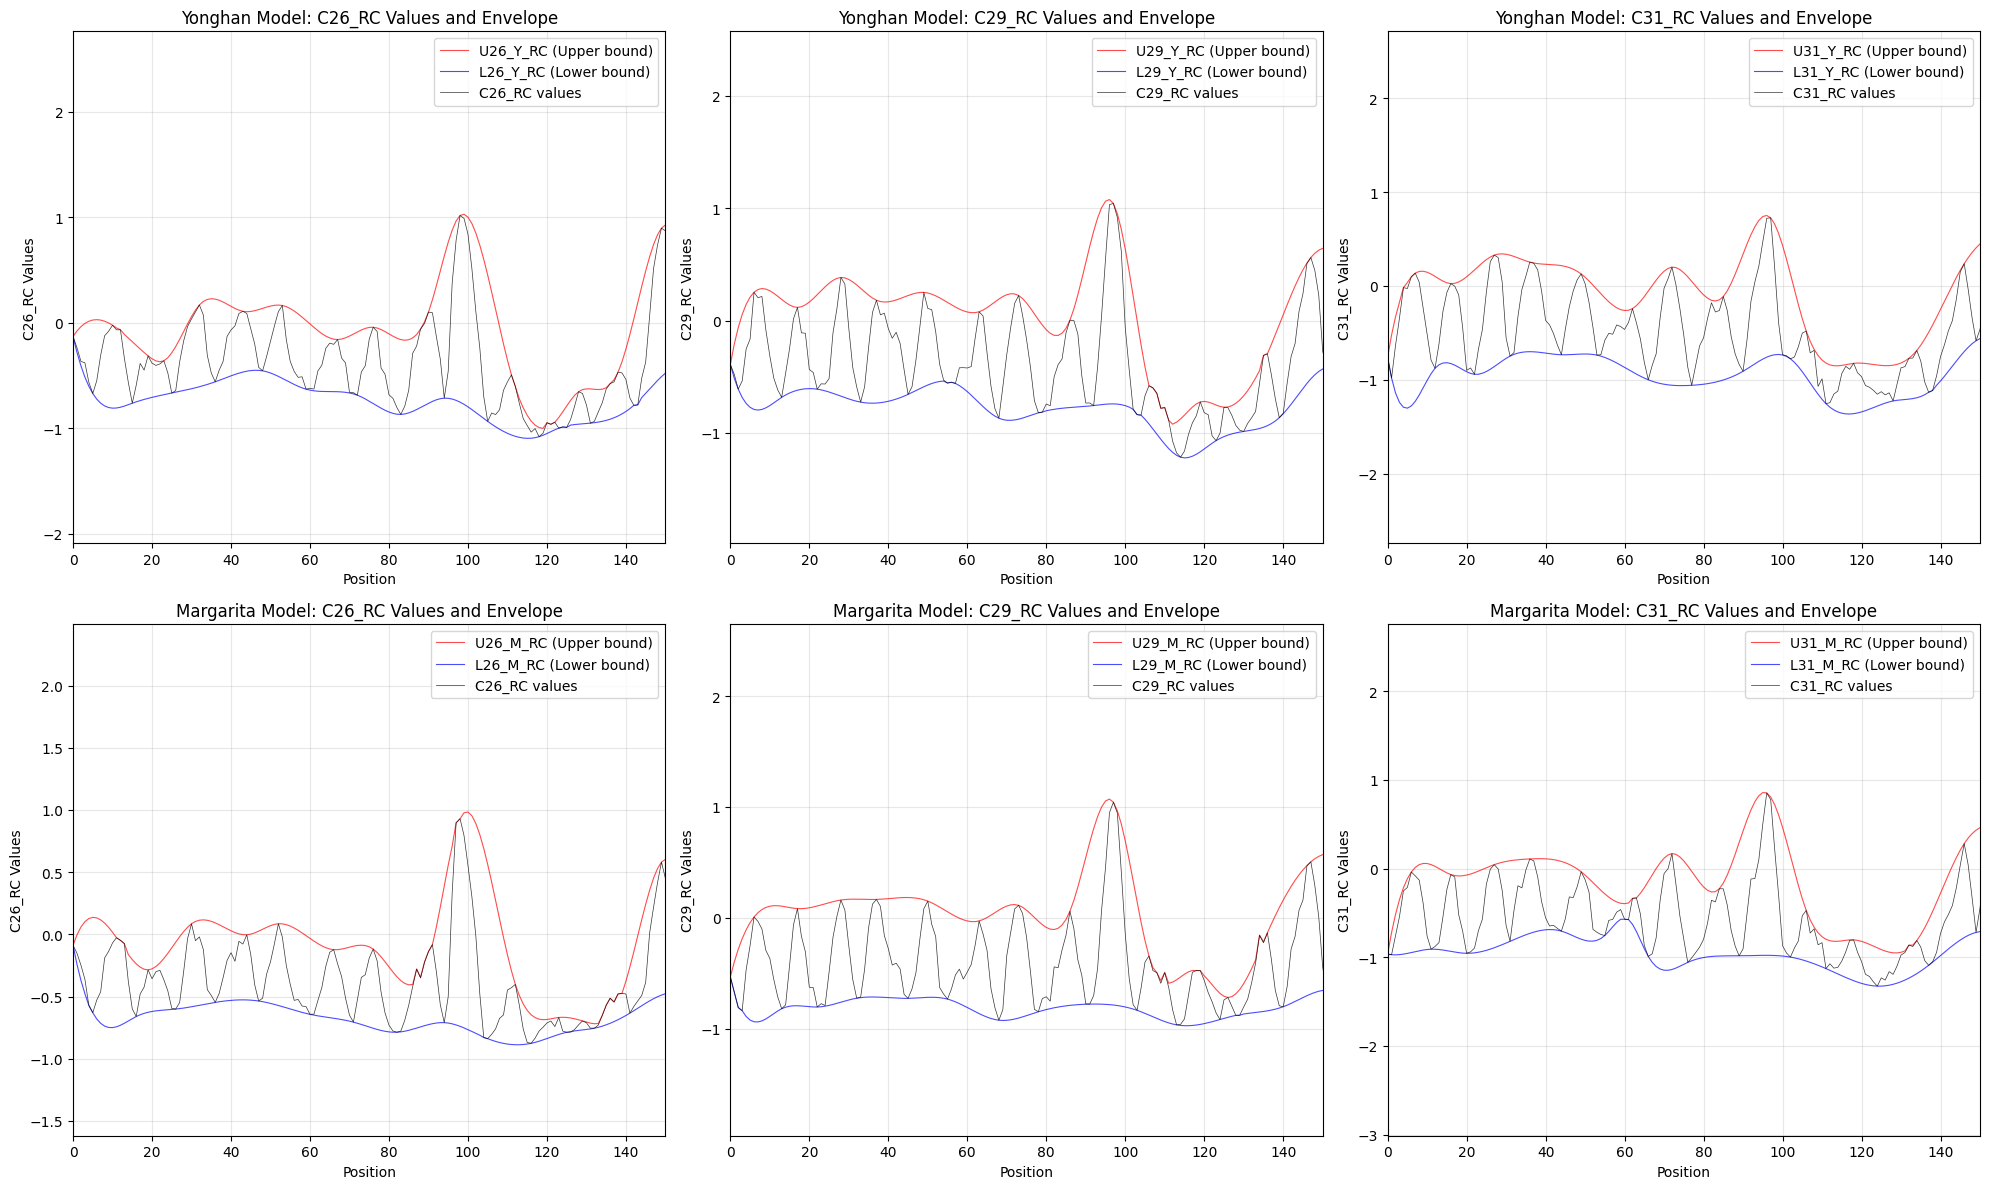

In [28]:
# Plot the reverse complement envelope ranges for both models

plt.figure(figsize=(20, 12))

# Define data for both models with RC data
models = {
  'Yonghan': {'U26_RC': U26_Y_RC, 'L26_RC': L26_Y_RC, 'C26_RC': Y_C26_chrV_RC, 
        'U29_RC': U29_Y_RC, 'L29_RC': L29_Y_RC, 'C29_RC': Y_C29_chrV_RC,
        'U31_RC': U31_Y_RC, 'L31_RC': L31_Y_RC, 'C31_RC': Y_C31_chrV_RC},
  'Margarita': {'U26_RC': U26_M_RC, 'L26_RC': L26_M_RC, 'C26_RC': M_C26_chrV_RC,
          'U29_RC': U29_M_RC, 'L29_RC': L29_M_RC, 'C29_RC': M_C29_chrV_RC, 
          'U31_RC': U31_M_RC, 'L31_RC': L31_M_RC, 'C31_RC': M_C31_chrV_RC}
}

# Loop through models and chain lengths
for model_idx, (model_name, data) in enumerate(models.items()):
  for chain_idx, chain_length in enumerate([26, 29, 31]):
    subplot_idx = model_idx * 3 + chain_idx + 1
    plt.subplot(2, 3, subplot_idx)
    
    # Plot upper and lower bounds and chain values for RC
    plt.plot(x, data[f'U{chain_length}_RC'], label=f'U{chain_length}_{model_name[0]}_RC (Upper bound)', 
        alpha=0.7, linewidth=0.8, color='red')
    plt.plot(x, data[f'L{chain_length}_RC'], label=f'L{chain_length}_{model_name[0]}_RC (Lower bound)', 
        alpha=0.7, linewidth=0.8, color='blue')
    plt.plot(x, data[f'C{chain_length}_RC'], label=f'C{chain_length}_RC values', 
        alpha=0.8, linewidth=0.5, color='black')
    
    plt.xlim(0, 150)
    plt.xlabel('Position')
    plt.ylabel(f'C{chain_length}_RC Values')
    plt.title(f'{model_name} Model: C{chain_length}_RC Values and Envelope')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### iv. Calculating $C_{0, \rm free}$ = $C_{0, \rm corr}$

In [29]:
def theta(n):
    return (60.5 - n) / 10.3 * 2*np.pi - 2*np.pi/3 # psi term not needed to solve for C0_corr/C0_free

ns = np.array([26., 29., 31.])
th = theta(ns)

X = np.column_stack([
    np.ones(3),
    np.cos(th),
    np.sin(th)
])

X_inv = np.linalg.inv(X)   # fixed 3×3 inverse


def get_offset(y3):
    """Extract U0 or L0 from [U26, U29, U31] or [L26, L29, L31]."""
    return (X_inv @ np.asarray(y3, float))[0]

In [30]:
n = len(x)

# Predict C0corr on sequences
U0_Y = np.zeros(n)
L0_Y = np.zeros(n)
for i in range(n):
    U0_Y[i] = get_offset([U26_Y[i], U29_Y[i], U31_Y[i]])
    L0_Y[i] = get_offset([L26_Y[i], L29_Y[i], L31_Y[i]])

C0corr_Y = (U0_Y + L0_Y)/2

# Predict C0corr on reverse complement sequences
U0_Y_RC = np.zeros(n)
L0_Y_RC = np.zeros(n)
for i in range(n):
    U0_Y_RC[i] = get_offset([U26_Y_RC[i], U29_Y_RC[i], U31_Y_RC[i]])
    L0_Y_RC[i] = get_offset([L26_Y_RC[i], L29_Y_RC[i], L31_Y_RC[i]])

C0corr_Y_RC = (U0_Y_RC + L0_Y_RC)/2

# Average C0corr
C0corr_Y_avg = (C0corr_Y + C0corr_Y_RC)/2

# Predict C0corr on sequences
U0_M = np.zeros(n)
L0_M = np.zeros(n)
for i in range(n):
    U0_M[i] = get_offset([U26_M[i], U29_M[i], U31_M[i]])
    L0_M[i] = get_offset([L26_M[i], L29_M[i], L31_M[i]])

C0corr_M = (U0_M + L0_M)/2

# Predict C0corr on reverse complement sequences
U0_M_RC = np.zeros(n)
L0_M_RC = np.zeros(n)
for i in range(n):
    U0_M_RC[i] = get_offset([U26_M_RC[i], U29_M_RC[i], U31_M_RC[i]])
    L0_M_RC[i] = get_offset([L26_M_RC[i], L29_M_RC[i], L31_M_RC[i]])

C0corr_M_RC = (U0_M_RC + L0_M_RC)/2

# Average C0corr
C0corr_M_avg = (C0corr_M + C0corr_M_RC)/2


# Compare the C0corr values between the two models
r, se_z, prec, d_low, d_high = ce.pearson(C0corr_Y, C0corr_M)
print(f'C0corr correlation between Yonghan and Margarita models: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# Also compare the reverse complement values
r, se_z, prec, d_low, d_high = ce.pearson(C0corr_Y_RC, C0corr_M_RC)
print(f'C0corr_RC correlation between Yonghan and Margarita models: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

# Compare the averaged values  
r, se_z, prec, d_low, d_high = ce.pearson(C0corr_Y_avg, C0corr_M_avg)
print(f'C0corr_avg correlation between Yonghan and Margarita models: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

C0corr correlation between Yonghan and Margarita models: 0.9694, [-0.0002, 0.0002]
C0corr_RC correlation between Yonghan and Margarita models: 0.9699, [-0.0002, 0.0002]
C0corr_avg correlation between Yonghan and Margarita models: 0.9799, [-0.0001, 0.0001]


In [33]:
# create dataframe with sequences and Margarita averaged C0 correction
assert len(chrV_1bpSeqs) == len(C0corr_M_avg), "Length mismatch between sequences and C0corr_M_avg"

df_chrV_C0corr_M = pd.DataFrame({
  'Sequence': chrV_1bpSeqs,
  'C0corr': C0corr_M_avg
})

display(df_chrV_C0corr_M.head())
save = False

if save:
  df_chrV_C0corr_M.to_csv('../Data/ChrV/ChrV_M_adapterfree.dat', sep='\t', index=False, float_format='%.7f', header=['Sequence', 'C0free'])

,Sequence,C0corr
0,ACTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTT...,-0.637606
1,CTTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTA...,-0.594615
2,TTACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTAT...,-0.559611
3,TACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATC...,-0.530877
4,ACTACCTTTATTTTATGTTTACTTTTTATAGATTGTCTTTTTATCC...,-0.515823


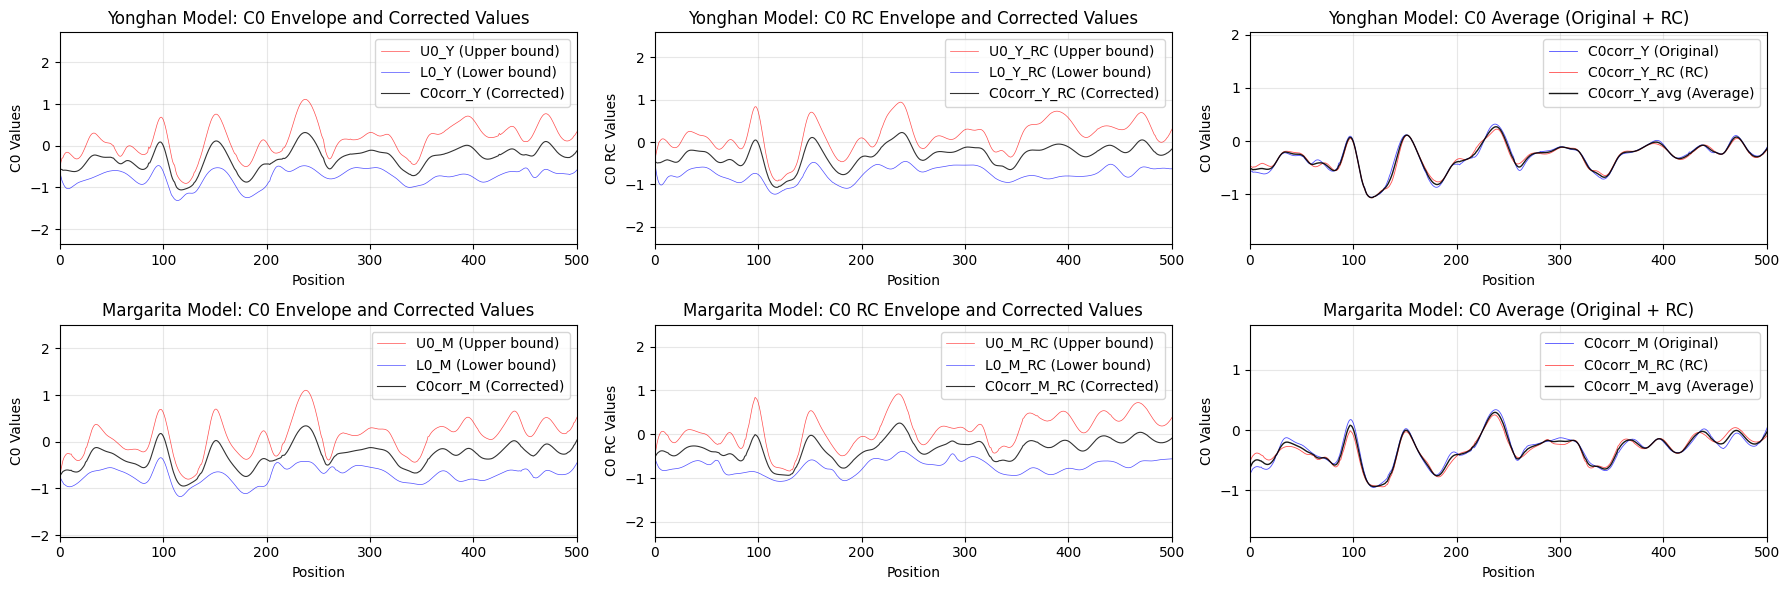

In [31]:
plt.figure(figsize=(18, 6))

# Define data for both models including RC and average data
models = {
  'Yonghan': {'U0': U0_Y, 'L0': L0_Y, 'C0corr': C0corr_Y, 
              'U0_RC': U0_Y_RC, 'L0_RC': L0_Y_RC, 'C0corr_RC': C0corr_Y_RC,
              'C0corr_avg': C0corr_Y_avg},
  'Margarita': {'U0': U0_M, 'L0': L0_M, 'C0corr': C0corr_M,
                'U0_RC': U0_M_RC, 'L0_RC': L0_M_RC, 'C0corr_RC': C0corr_M_RC,
                'C0corr_avg': C0corr_M_avg}
}

# Create subplots: 2 rows, 3 columns
subplot_titles = ['C0 Envelope and Corrected Values', 'C0 RC Envelope and Corrected Values', 
                  'C0 Average (Original + RC)']

for model_idx, (model_name, data) in enumerate(models.items()):
    # Original sequences
    plt.subplot(2, 3, model_idx * 3 + 1)
    plt.plot(x, data['U0'], label=f'U0_{model_name[0]} (Upper bound)', alpha=0.7, linewidth=0.5, color='red')
    plt.plot(x, data['L0'], label=f'L0_{model_name[0]} (Lower bound)', alpha=0.7, linewidth=0.5, color='blue')
    plt.plot(x, data['C0corr'], label=f'C0corr_{model_name[0]} (Corrected)', alpha=0.8, linewidth=0.8, color='black')
    plt.xlim(0, 500)
    plt.xlabel('Position')
    plt.ylabel('C0 Values')
    plt.title(f'{model_name} Model: {subplot_titles[0]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Reverse complement sequences
    plt.subplot(2, 3, model_idx * 3 + 2)
    plt.plot(x, data['U0_RC'], label=f'U0_{model_name[0]}_RC (Upper bound)', alpha=0.7, linewidth=0.5, color='red')
    plt.plot(x, data['L0_RC'], label=f'L0_{model_name[0]}_RC (Lower bound)', alpha=0.7, linewidth=0.5, color='blue')
    plt.plot(x, data['C0corr_RC'], label=f'C0corr_{model_name[0]}_RC (Corrected)', alpha=0.8, linewidth=0.8, color='black')
    plt.xlim(0, 500)
    plt.xlabel('Position')
    plt.ylabel('C0 RC Values')
    plt.title(f'{model_name} Model: {subplot_titles[1]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Average of original and RC
    plt.subplot(2, 3, model_idx * 3 + 3)
    plt.plot(x, data['C0corr'], label=f'C0corr_{model_name[0]} (Original)', alpha=0.7, linewidth=0.6, color='blue')
    plt.plot(x, data['C0corr_RC'], label=f'C0corr_{model_name[0]}_RC (RC)', alpha=0.7, linewidth=0.6, color='red')
    plt.plot(x, data['C0corr_avg'], label=f'C0corr_{model_name[0]}_avg (Average)', alpha=0.9, linewidth=1.0, color='black')
    plt.xlim(0, 500)
    plt.xlabel('Position')
    plt.ylabel('C0 Values')
    plt.title(f'{model_name} Model: {subplot_titles[2]}')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 3. Training the Adapter-Free models

### 3a. Yonghans Model

In [ ]:
# training Yonghans Model for C0corr (adapter free) predictions

save = False
overwrite = False
average = True
Avg = 'Avg' if average else '' 
dir = '../CNN_models/RC_invariant/Yonghan/'

try:
  assert os.path.exists(f'{dir}Y_C0free{Avg}.keras'), "Yonghan C0free model file does not exist"
  assert (overwrite == False)
  Y_C0free = tf.keras.models.load_model(f'{dir}Y_C0free{Avg}.keras')

except Exception as e:
  Y_C0free = ce.YonghansArchitecture()
  Y_C0free.fit(chrV_1bpOnehot, C0corr_Y_avg.reshape(-1, 1), epochs = 2, validation_split = 0.1)
  if save:
    Y_C0free.save(f'{dir}Y_C0free{Avg}.keras')

In [229]:
# check correlation of Y_C0free on training data
trainingPredictions = Y_C0free.predict(chrV_1bpOnehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C0corr_Y.reshape(-1, 1), trainingPredictions)
print(f'Y_C0free Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

2231/2231 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Y_C0free Correlation on training data: 0.9745, [-0.0001, 0.0001]


In [230]:
# predict c0 values for sequences and their onehot
Predictions = Y_C0free.predict(TestOnehot, batch_size = 256)
Predictions_RC = Y_C0free.predict(TestOnehot_RC, batch_size = 256)

r, se_z, prec, d_low, d_high = ce.pearson(Predictions, Predictions_RC)
print(f'Correlation of Yonghans model on reverse complement sequences: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Correlation of Yonghans model on reverse complement sequences: 0.9861, [-0.0003, 0.0003]


### 3b. Margaritas Model

In [ ]:
# training Margaritas Model for C0corr (adapter free) predictions

save = False
overwrite = False
average = True
Avg = 'Avg' if average else '' 
dir = '../CNN_models/RC_invariant/Margarita/'

try:
  assert os.path.exists(f'{dir}M_C0free{Avg}.keras'), "Margarita C0free model file does not exist"
  assert (overwrite == False)
  M_C0free = tf.keras.models.load_model(f'{dir}M_C0free{Avg}.keras')

except Exception as e:
  M_C0free = ce.MargaritasArchitecture(Kernel=KERNEL_SHAPE)
  M_C0free.fit(chrV_1bpOnehot, C0corr_M_avg.reshape(-1, 1), epochs = 2, validation_split = 0.1)

  if save:
    M_C0free.save(f'{dir}M_C0free{Avg}.keras')

In [235]:
# check correlation of Y_C0free on training data
trainingPredictions = M_C0free.predict(chrV_1bpOnehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C0corr_M.reshape(-1, 1), trainingPredictions)
print(f'Y_C0free Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

2231/2231 ━━━━━━━━━━━━━━━━━━━━ 116s 52ms/step
Y_C0free Correlation on training data: 0.9739, [-0.0001, 0.0001]


In [236]:
# predict c0 values for sequences and their onehot
Predictions = M_C0free.predict(TestOnehot, batch_size = 256)
Predictions_RC = M_C0free.predict(TestOnehot_RC, batch_size = 256)

r, se_z, prec, d_low, d_high = ce.pearson(Predictions, Predictions_RC)
print(f'Correlation of Margaritas model on reverse complement wequences: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step
Correlation of Symmetric Model on Reverse Complement Sequences: 0.9852, [-0.0003, 0.0003]


### 3c. Symmetric Model

In [ ]:
# training Symmetric Model for C0corr (adapter free) predictions

save = False
overwrite = False
average = True
Avg = 'Avg' if average else '' 
dir = '../CNN_models/RC_invariant/Symmetric/'

try:
  assert os.path.exists(f'{dir}S_C0free{Avg}.keras'), "Symmetric C0free model file does not exist"
  assert (overwrite == False)
  S_C0free = tf.keras.models.load_model(f'{dir}S_C0free{Avg}.keras')

except Exception as e:
  S_C0free = ce.SymmetricArchitecture(Kernel=KERNEL_SHAPE)
  S_C0free.fit([chrV_1bpOnehot, chrV_1bpOnehotRC], C0corr_M_avg.reshape(-1, 1), epochs=2, validation_split = 0.1)

  if save:
    S_C0free.save(f'{dir}S_C0free{Avg}.keras')

In [238]:
# check correlation of Y_C0free on training data
trainingPredictions = S_C0free.predict(chrV_1bpOnehot, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(C0corr_M.reshape(-1, 1), trainingPredictions)
print(f'S_C0free Correlation on training data: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

2231/2231 ━━━━━━━━━━━━━━━━━━━━ 112s 50ms/step
S_C0free Correlation on training data: 0.9742, [-0.0001, 0.0001]


In [239]:
# predict c0 values for sequences and their onehot
Predictions = S_C0free.predict(TestOnehot, batch_size = 256)
Predictions_RC = S_C0free.predict(TestOnehot_RC, batch_size = 256)

r, se_z, prec, d_low, d_high = ce.pearson(Predictions, Predictions_RC)
print(f'Correlation of Symmetric model on reverse complement sequences: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step
178/178 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step
Correlation of Symmetric model on reverse complement sequences: 0.9924, [-0.0001, 0.0001]


In [240]:
seqArray = ce.GenerateSyntheticSeqs(200_000)
seqArrayRC = ce.Data2Onehot(ce.SeqArr2RevCompArr(ce.Onehot2Data(seqArray)))

display(pd.DataFrame(seqArray).head())
display(pd.DataFrame(seqArrayRC).head())

seqArray = seqArray.reshape(-1,200,1)
seqArrayRC = seqArrayRC.reshape(-1,200,1)

Encoded all sequences to onehot


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,0,1,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,1,0,0
1,0,1,0,0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,1
2,0,0,1,0,0,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,0,1
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
2,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,0,0,0,1,1,0,0,0,0,1,...,1,0,1,0,0,0,0,0,1,0


In [241]:
Y_pred = Y_C0free.predict(seqArray, batch_size = 256)
Y_predRC = Y_C0free.predict(seqArrayRC, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(Y_pred, Y_predRC)
print(f'Correlation of Yonghans model on reverse complement sequences: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

M_pred = M_C0free.predict(seqArray, batch_size = 256)
M_predRC = M_C0free.predict(seqArrayRC, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(M_pred, M_predRC)
print(f'Correlation of Margaritas model on reverse complement sequences: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

S_pred = S_C0free.predict(seqArray, batch_size = 256)
S_predRC = S_C0free.predict(seqArrayRC, batch_size = 256)
r, se_z, prec, d_low, d_high = ce.pearson(S_pred, S_predRC)
print(f'Correlation of Symmetric model on reverse complement sequences: {r:.{prec}f}, [{d_low:.{prec}f}, {d_high:.{prec}f}]')

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Correlation of Yonghans model on reverse complement sequences: 0.9819, [-0.0002, 0.0002]
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step
Correlation of Margaritas model on reverse complement sequences: 0.9805, [-0.0002, 0.0002]
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 52ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step
Correlation of Symmetric model on reverse complement sequences: 0.98963, [-0.00009, 0.00009]


### Training `Adapter-Free` $C_0$ models

#### Yonghan's Model on $C_{0, \rm corr}$**:
On training data: r = 0.9800, [-0.0001, 0.0001] <br>
On reverse complement data: r = 0.9680, [-0.0003, 0.0003] <br>
<br>
**Yonghan's Model on $C_{0, \rm corr}{\rm avg}$**: <br>
On training data: 0.9745, [-0.0001, 0.0001] <br>
On reverse complement data: 0.9819, [-0.0002, 0.0002] <br>

#### Margaritas's Model on $C_{0, \rm corr}$**:
On training data: r = 0.9783, [-0.0001, 0.0001] <br>
On reverse complement data: r = 0.9649, [-0.003, 0.003] <br>
<br>
**Margaritas's Model on $C_{0, \rm corr}{\rm avg}$**: <br>
On training data: 0.9739, [-0.0001, 0.0001] <br>
On reverse complement data: 0.9805, [-0.0002, 0.0002] <br>

#### Symmetric's Model on $C_{0, \rm corr}$:
On training data: r = 0.9784, [-0.0001, 0.0001] <br>
On reverse complement data: r = 0.9864, [-0.0001, 0.0001] <br>
<br>
**Symmetric's Model on $C_{0, \rm corr}{\rm avg}$**: <br>
On training data: 0.9742, [-0.0001, 0.0001] <br>
On reverse complement data: 0.98963, [-0.00009, 0.00009] <br>